In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import LeaveOneGroupOut
import matplotlib.pyplot as plt

In [2]:
D = pd.read_hdf('//FS2.smpp.local\RTO\CIS-PD MUSC\decoded_forms\\form509.h5')

In [3]:
sum(D.Q03=='Left')/len(D)

0.6700507614213198

## Tremor Scores

In [4]:
taskList = np.array(['Standing', 'Walking', 'Walking while counting', 'Finger to nose--right hand', 
                     'Finger to nose--left hand', 'Alternating right hand movements', 
                     'Alternating left hand movements', 'Sit to stand', 'Drawing on a paper', 
                     'Typing on a computer keyboard', 'Assembling nuts and bolts', 
                     'Taking a glass of water and drinking', 'Organizing sheets in a folder', 'Folding towels', 
                     'Sitting'])
taskList_Abb = np.array(['Stndg', 'Wlkg', 'WlkgCnt', 'FtnR', 'FtnL', 'RamR', 'RamL', 'SitStand', 
                         'Drwg', 'Typg', 'NtsBts', 'Drnkg', 'Sheets', 'Fldg', 'Sitng'])

In [5]:
Questions = pd.read_sas('//FS2.smpp.local\RTO\CIS-PD MUSC\datadictionary.sas7bdat')
Questions = Questions[Questions.zFormID == 509.0]
Questions = Questions.drop(columns = list(set(Questions.columns)-set(['zFieldNm','zFieldNb'])))
Questions.zFieldNm = Questions.zFieldNm.apply(
    lambda x: x.replace(b'\x92',b"'").replace(b'\x97',b'--').decode() if isinstance(x, bytes) else x)
Questions.zFieldNb = Questions.zFieldNb.apply(
    lambda x: x.replace(b'\x92',b"'").replace(b'\x97',b'--').decode() if isinstance(x, bytes) else x)
## Correct Typos
Questions.loc[Questions.zFieldNm=='Walking  tremor left upper limb rating','zFieldNm'] = 'Walking tremor left upper limb rating'
Questions.loc[Questions.zFieldNb=='Q70','zFieldNm'] = 'Alternating left hand movements tremor right upper limb rating'
Questions.loc[Questions.zFieldNb=='Q145','zFieldNm'] = 'Sitting tremor right upper limb rating'

In [6]:
AllScores = pd.DataFrame()
for ind in D.index:
    row = D.loc[ind,:]
    side = row.Q03
    if side == 'left':
        SideDict = {'FtnR': 'FtnC', 'FtnL': 'FtnI', 'RamR':'RamC', 'RamL':'RamI'}
    else:
        SideDict = {'FtnR': 'FtnI', 'FtnL': 'FtnC', 'RamR':'RamI', 'RamL':'RamC'}
        
    try:
        side = side.lower()
    except(AttributeError):
        print(row.SubjectCode, row.VisitNm, row.Q03)
        continue
    RowScores = pd.DataFrame(columns=taskList_Abb, index=[ind])
    for task, task_abr in zip(taskList,taskList_Abb):
        QInd = Questions.zFieldNm==task+' tremor '+side+' upper limb rating'
        QNum = Questions[QInd].zFieldNb
#         print(task+' tremor '+side+' upper limb rating',row[QNum].values)
        if task_abr in SideDict.keys():
            task_abr=SideDict[task_abr]
        RowScores[task_abr] = row[QNum].values[0]
    RowScores.index = [(row.SubjectCode,row.VisitNm)]
    AllScores = pd.concat((AllScores,RowScores))
    

1005.0 2 Weeks: Time 120 nan
1005.0 1 Month nan
1020.0 2 Weeks: Time 0 nan
1020.0 2 Weeks: Time 30 nan
1020.0 2 Weeks: Time 60 nan
1020.0 2 Weeks: Time 90 nan
1020.0 2 Weeks: Time 120 nan
1020.0 2 Weeks: Time 150 nan
1047.0 1 Month nan
1048.0 2 Weeks: Time 150 nan


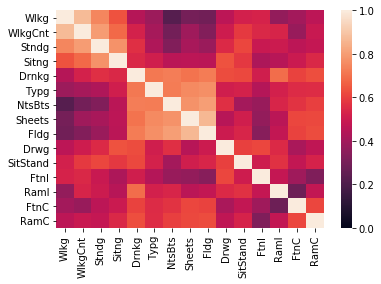

In [7]:
sns.heatmap(AllScores.corr().loc[['Wlkg','WlkgCnt','Stndg','Sitng','Drnkg','Typg','NtsBts','Sheets','Fldg','Drwg','SitStand','FtnI','RamI','FtnC','RamC'],
                                 ['Wlkg','WlkgCnt','Stndg','Sitng','Drnkg','Typg','NtsBts','Sheets','Fldg','Drwg','SitStand','FtnI','RamI','FtnC','RamC']]
           ,vmin=0, vmax=1)

In [8]:
AllScoresRMSE = pd.DataFrame(columns=AllScores.columns, index =AllScores.columns)
for x,y in itertools.product(AllScores.columns,AllScores.columns):
    AllScoresRMSE.loc[x,y] = ((AllScores[x]-AllScores[y])**2).mean()**.5

In [9]:
AllScoresRMSE = AllScoresRMSE[AllScoresRMSE.columns].astype(float)

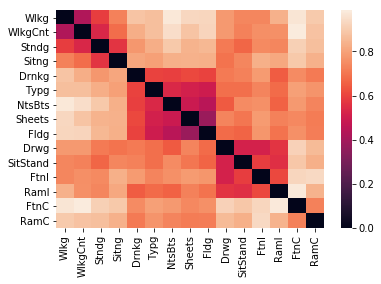

In [10]:
sns.heatmap(AllScoresRMSE.loc[['Wlkg','WlkgCnt','Stndg','Sitng','Drnkg','Typg','NtsBts','Sheets','Fldg','Drwg','SitStand','FtnI','RamI','FtnC','RamC'],
                              ['Wlkg','WlkgCnt','Stndg','Sitng','Drnkg','Typg','NtsBts','Sheets','Fldg','Drwg','SitStand','FtnI','RamI','FtnC','RamC']]
           ,vmin=0)

In [11]:
Tremor = AllScores
Tremor.drop(columns=['RamR','RamL','FtnR','FtnL'], inplace=True)
Tremor.columns = [c+'_T' for c in Tremor.columns]

## Bradykinesia Scores

In [12]:
taskList = np.array(['Walking', 'Walking while counting', 'Finger to nose--right hand', 
                     'Finger to nose--left hand', 'Alternating right hand movements', 
                     'Alternating left hand movements', 'Drawing on a paper', 
                     'Typing on a computer keyboard', 'Assembling nuts and bolts', 
                     'Taking a glass of water and drinking', 'Organizing sheets in a folder', 'Folding towels'])
taskList_Abb = np.array(['Wlkg', 'WlkgCnt', 'FtnR', 'FtnL', 'RamR', 'RamL', 
                         'Drwg', 'Typg', 'NtsBts', 'Drnkg', 'Sheets', 'Fldg'])

In [13]:
Questions = pd.read_sas('//FS2.smpp.local\RTO\CIS-PD MUSC\datadictionary.sas7bdat')
Questions = Questions[Questions.zFormID == 509.0]
Questions = Questions.drop(columns = list(set(Questions.columns)-set(['zFieldNm','zFieldNb'])))
Questions.zFieldNm = Questions.zFieldNm.apply(
    lambda x: x.replace(b'\x92',b"'").replace(b'\x97',b'--').decode() if isinstance(x, bytes) else x)
Questions.zFieldNb = Questions.zFieldNb.apply(
    lambda x: x.replace(b'\x92',b"'").replace(b'\x97',b'--').decode() if isinstance(x, bytes) else x)

In [14]:
AllScores = pd.DataFrame()
for ind in D.index:
    row = D.loc[ind,:]
    side = row.Q03
    if side == 'Left':
        SideDict = {'FtnR': 'FtnC', 'FtnL': 'FtnI', 'RamR':'RamC', 'RamL':'RamI'}
    else:
        SideDict = {'FtnR': 'FtnI', 'FtnL': 'FtnC', 'RamR':'RamI', 'RamL':'RamC'}
        
    try:
        side = side.lower()
    except(AttributeError):
        print(row.SubjectCode, row.VisitNm, row.Q03)
        continue
    RowScores = pd.DataFrame(columns=taskList_Abb, index=[ind])
    for task, task_abr in zip(taskList,taskList_Abb):
        if (task_abr[-1].lower()!=side[0])&((task_abr[-1]=='R')|(task_abr[-1]=='L')):
            continue
        QInd = Questions.zFieldNm==task+' bradykinesia '+side+' upper limb'
        if sum(QInd)<1:
            QInd = Questions.zFieldNm==task+' bradykinesia '+side+' upper limb rating'
        QNum = Questions[QInd].zFieldNb
#         print(task+' tremor '+side+' upper limb rating',row[QNum].values)
        if task_abr in SideDict.keys():
            task_abr=SideDict[task_abr]
        RowScores[task_abr] = row[QNum].values[0]
    RowScores.index = [(row.SubjectCode,row.VisitNm)]
    AllScores = pd.concat((AllScores,RowScores))
    

1005.0 2 Weeks: Time 120 nan
1005.0 1 Month nan
1020.0 2 Weeks: Time 0 nan
1020.0 2 Weeks: Time 30 nan
1020.0 2 Weeks: Time 60 nan
1020.0 2 Weeks: Time 90 nan
1020.0 2 Weeks: Time 120 nan
1020.0 2 Weeks: Time 150 nan
1047.0 1 Month nan
1048.0 2 Weeks: Time 150 nan


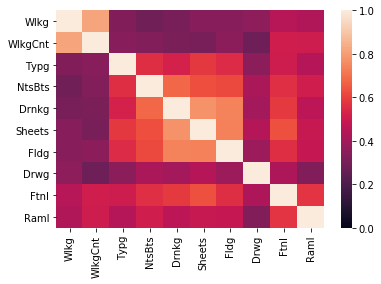

In [15]:
sns.heatmap(AllScores.corr().loc[['Wlkg','WlkgCnt','Typg','NtsBts','Drnkg','Sheets','Fldg','Drwg','FtnI','RamI'],
                                 ['Wlkg','WlkgCnt','Typg','NtsBts','Drnkg','Sheets','Fldg','Drwg','FtnI','RamI']],vmin=0, vmax=1)

In [16]:
AllScoresRMSE = pd.DataFrame(columns=AllScores.columns, index =AllScores.columns)
for x,y in itertools.product(AllScores.columns,AllScores.columns):
    AllScoresRMSE.loc[x,y] = ((AllScores[x]-AllScores[y])**2).mean()**.5

In [17]:
AllScoresRMSE = AllScoresRMSE[AllScoresRMSE.columns].astype(float)

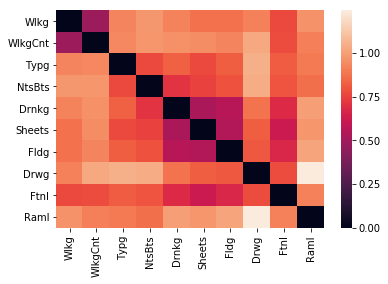

In [18]:
sns.heatmap(AllScoresRMSE.loc[['Wlkg','WlkgCnt','Typg','NtsBts','Drnkg','Sheets','Fldg','Drwg','FtnI','RamI'],
                              ['Wlkg','WlkgCnt','Typg','NtsBts','Drnkg','Sheets','Fldg','Drwg','FtnI','RamI']],vmin=0)

In [19]:
Brady = AllScores
Brady.drop(columns=['RamR','RamL','FtnR','FtnL'], inplace=True)
Brady.columns = [c+'_B' for c in Brady.columns]

## Corrleate with MDS-UPDRS

In [20]:
AllScores = pd.concat((Tremor,Brady),axis=1)

#### Extract MDS-UPDRS Scores

In [21]:
form508 = pd.read_hdf('//FS2.smpp.local\\RTO\\CIS-PD MUSC\\decoded_forms\\form508.h5')

In [22]:
form508.head(2)

,SubjectCode,SiteID,VisitNm,FormDate,Q33,Q34,Q35,Q36,Q37,Q38,...,Q64,Q65,Q02,Q01,Q66,Q67,Q68,DataCollected,Qb2_UTC,FormTime
0,1003.0,1313.0,2 Weeks: Time 0,2017-07-03,2.0,2.0,2.0,2.0,2.0,2.0,...,0.0,1.0,NaN,Off,No,NaN,Severe disability; still able to walk or stand...,Yes,2017-07-03 15:20:44,10:20:44
1,1003.0,1313.0,2 Weeks: Time 60,2017-07-03,1.0,2.0,2.0,2.0,2.0,2.0,...,0.0,0.0,NaN,On,No,NaN,Bilateral involvement without impairment of ba...,Yes,2017-07-03 17:11:39,12:11:39


In [23]:
UPDRS = form508[['SubjectCode', 'VisitNm', 'Q01', 'Q33', 'Q34', 'Q35', 'Q36', 'Q37', 'Q38', 'Q39', 'Q40', 'Q41', 'Q42', 'Q43', 'Q44', 'Q45',
         'Q46', 'Q47', 'Q48', 'Q49', 'Q50', 'Q51', 'Q52', 'Q53', 'Q54', 'Q55',
         'Q56', 'Q57', 'Q58', 'Q59', 'Q60', 'Q61', 'Q62', 'Q63', 'Q64', 'Q65']].copy()
UPDRS.index = [(row[1].SubjectCode,row[1].VisitNm) for row in UPDRS.iterrows()]

In [24]:
UPDRS['UPDRS Part III'] = UPDRS[['Q33', 'Q34', 'Q35', 'Q36', 'Q37', 'Q38', 'Q39', 'Q40', 'Q41', 'Q42', 'Q43', 'Q44', 'Q45',
         'Q46', 'Q47', 'Q48', 'Q49', 'Q50', 'Q51', 'Q52', 'Q53', 'Q54', 'Q55',
         'Q56', 'Q57', 'Q58', 'Q59', 'Q60', 'Q61', 'Q62', 'Q63', 'Q64', 'Q65']].apply(sum,axis=1)
UPDRS['UPDRS Rigidity'] = UPDRS[['Q35', 'Q36', 'Q37', 'Q38', 'Q39']].apply(sum,axis=1)
UPDRS['UPDRS Upper'] = UPDRS[['Q40', 'Q41', 'Q42', 'Q43', 'Q44', 'Q45']].apply(sum,axis=1)
UPDRS['UPDRS Lower'] = UPDRS[['Q46', 'Q47', 'Q48', 'Q49']].apply(sum,axis=1)
UPDRS['UPDRS Posture/Gait'] = UPDRS[['Q50', 'Q51', 'Q52', 'Q53', 'Q54']].apply(sum,axis=1)
UPDRS['UPDRS Bradykinesia'] = UPDRS[['Q55']].apply(sum,axis=1)
UPDRS['UPDRS Tremor'] = UPDRS[['Q56', 'Q57', 'Q58', 'Q59', 'Q60', 'Q61', 'Q62', 'Q63', 'Q64', 'Q65']].apply(sum,axis=1)

In [25]:
UPDRS

,SubjectCode,VisitNm,Q01,Q33,Q34,Q35,Q36,Q37,Q38,Q39,...,Q63,Q64,Q65,UPDRS Part III,UPDRS Rigidity,UPDRS Upper,UPDRS Lower,UPDRS Posture/Gait,UPDRS Bradykinesia,UPDRS Tremor
"(1003.0, 2 Weeks: Time 0)",1003.0,2 Weeks: Time 0,Off,2.0,2.0,2.0,2.0,2.0,2.0,1.0,...,0.0,0.0,1.0,59.0,9.0,13.0,11.0,11.0,3.0,8.0
"(1003.0, 2 Weeks: Time 60)",1003.0,2 Weeks: Time 60,On,1.0,2.0,2.0,2.0,2.0,2.0,1.0,...,0.0,0.0,0.0,40.0,9.0,12.0,6.0,3.0,2.0,5.0
"(1004.0, 2 Weeks: Time 0)",1004.0,2 Weeks: Time 0,Off,1.0,1.0,0.0,1.0,2.0,1.0,1.0,...,0.0,0.0,0.0,31.0,5.0,9.0,8.0,1.0,2.0,4.0
"(1004.0, 2 Weeks: Time 60)",1004.0,2 Weeks: Time 60,On,NaN,NaN,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,NaN,3.0,4.0,4.0,0.0,1.0,0.0
"(1005.0, 2 Weeks: Time 0)",1005.0,2 Weeks: Time 0,Off,1.0,1.0,1.0,1.0,2.0,1.0,2.0,...,0.0,0.0,1.0,33.0,7.0,8.0,8.0,2.0,2.0,4.0
"(1005.0, 2 Weeks: Time 60)",1005.0,2 Weeks: Time 60,On,1.0,1.0,2.0,0.0,3.0,0.0,2.0,...,0.0,0.0,1.0,32.0,7.0,8.0,5.0,2.0,1.0,7.0
"(1007.0, 2 Weeks: Time 0)",1007.0,2 Weeks: Time 0,Off,0.0,0.0,2.0,1.0,1.0,1.0,0.0,...,0.0,0.0,2.0,33.0,5.0,10.0,7.0,2.0,2.0,7.0
"(1007.0, 2 Weeks: Time 60)",1007.0,2 Weeks: Time 60,On,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,16.0,0.0,7.0,4.0,1.0,1.0,2.0
"(1009.0, 2 Weeks: Time 0)",1009.0,2 Weeks: Time 0,Off,1.0,2.0,3.0,3.0,2.0,3.0,2.0,...,0.0,0.0,4.0,55.0,13.0,12.0,6.0,3.0,2.0,16.0
"(1009.0, 2 Weeks: Time 60)",1009.0,2 Weeks: Time 60,On,1.0,1.0,2.0,2.0,2.0,1.0,0.0,...,0.0,0.0,1.0,26.0,7.0,5.0,4.0,2.0,2.0,4.0


In [26]:
UPDRS=UPDRS[['UPDRS Part III', 'UPDRS Rigidity', 'UPDRS Upper', 'UPDRS Lower', 
             'UPDRS Posture/Gait', 'UPDRS Bradykinesia', 'UPDRS Tremor']]

#### Combine UPDRS and Motor Assessment Scores

In [27]:
CombScores = pd.concat((AllScores,UPDRS),axis=1)

C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  """Entry point for launching an IPython kernel.


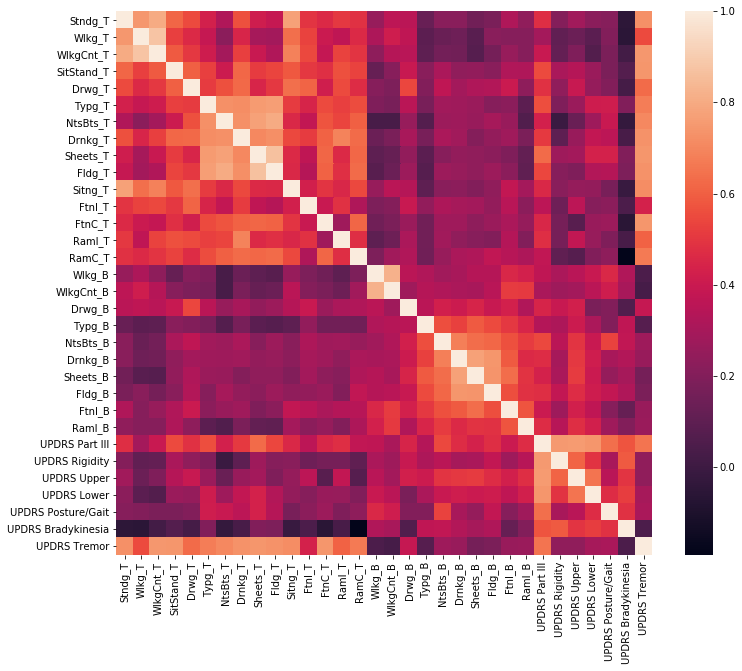

In [28]:
plt.figure(figsize=(12,10))
sns.heatmap(CombScores.corr())

In [47]:
CombScores.head()

Stndg_T  Wlkg_T  WlkgCnt_T  SitStand_T  Drwg_T  \
1003.0 2 Weeks: Time 0       1.0     0.0        0.0         0.0     1.0   
       2 Weeks: Time 60      0.0     0.0        0.0         1.0     0.0   
1004.0 2 Weeks: Time 0       0.0     0.0        0.0         0.0     0.0   
1005.0 2 Weeks: Time 0       0.0     0.0        0.0         1.0     1.0   
       2 Weeks: Time 60      0.0     0.0        0.0         1.0     1.0   

                         Typg_T  NtsBts_T  Drnkg_T  Sheets_T  Fldg_T  \
1003.0 2 Weeks: Time 0      0.0       1.0      1.0       2.0     1.0   
       2 Weeks: Time 60     0.0       0.0      1.0       0.0     0.0   
1004.0 2 Weeks: Time 0      1.0       1.0      0.0       1.0     1.0   
1005.0 2 Weeks: Time 0      1.0       1.0      1.0       1.0     1.0   
       2 Weeks: Time 60     1.0       1.0      1.0       1.0     1.0   

                             ...       Fldg_B  FtnI_B  RamI_B  UPDRS Part III  \
1003.0 2 Weeks: Time 0       ...          1.0     1.0     2.0            59.0   
       2 Weeks: Time 60      ...          0.0     0.0     2.0            40.0   
1004.0 2 Weeks: Time 0       ...          1.0     1.0     1.0            31.0   
1005.0 2 Weeks: Time 0       ...          2.0     2.0     3.0            33.0   
       2 Weeks: Time 60      ...          1.0     1.0     3.0            32.0   

                         UPDRS Rigidity  UPDRS Upper  UPDRS Lower  \
1003.0 2 Weeks: Time 0              9.0         13.0         11.0   
       2 Weeks: Time 60             9.0         12.0          6.0   
1004.0 2 Weeks: Time 0              5.0          9.0          8.0   
1005.0 2 Weeks: Time 0              7.0          8.0          8.0   
       2 Weeks: Time 60             7.0          8.0          5.0   

                         UPDRS Posture/Gait  UPDRS Bradykinesia  UPDRS Tremor  
1003.0 2 Weeks: Time 0                 11.0                 3.0           8.0  
       2 Weeks: Time 60                 3.0                 2.0           5.0  
1004.0 2 Weeks: Time 0                  1.0                 2.0           4.0  
1005.0 2 Weeks: Time 0                  2.0                 2.0           4.0  
       2 Weeks: Time 60                 2.0                 1.0           7.0  

[5 rows x 32 columns]

In [46]:
CombScores.corr().loc[['Stndg_T', 'Wlkg_T', 'WlkgCnt_T', 'SitStand_T', 'Drwg_T', 'Typg_T',
       'NtsBts_T', 'Drnkg_T', 'Sheets_T', 'Fldg_T', 'Sitng_T', 'FtnI_T',
       'FtnC_T', 'RamI_T', 'RamC_T', 'Wlkg_B', 'WlkgCnt_B', 'Drwg_B', 'Typg_B',
       'NtsBts_B', 'Drnkg_B', 'Sheets_B', 'Fldg_B', 'FtnI_B', 'RamI_B'],['UPDRS Part III']]

,UPDRS Part III
Stndg_T,0.492924
Wlkg_T,0.313435
WlkgCnt_T,0.399154
SitStand_T,0.571443
Drwg_T,0.506713
Typg_T,0.543592
NtsBts_T,0.423553
Drnkg_T,0.493483
Sheets_T,0.615890
Fldg_T,0.538609


### Random Forest for UPDRS Prediction

In [30]:
cf = RandomForestRegressor(n_estimators=50)
grouper = LeaveOneGroupOut()
CombScores.dropna(inplace=True)

In [31]:
CombScores.index.levels[0]

Float64Index([1003.0, 1004.0, 1005.0, 1007.0, 1009.0, 1016.0, 1018.0, 1019.0,
              1020.0, 1023.0, 1024.0, 1029.0, 1030.0, 1032.0, 1038.0, 1039.0,
              1043.0, 1044.0, 1046.0, 1047.0, 1048.0, 1049.0, 1050.0, 1051.0,
              1052.0, 1053.0, 1054.0, 1055.0, 1056.0],
             dtype='float64')

In [32]:
Outcomes = pd.DataFrame(index=CombScores.index,columns = ['UPDRS Part III', 'UPDRS Rigidity', 'UPDRS Upper', 'UPDRS Lower', 
                                                          'UPDRS Posture/Gait', 'UPDRS Bradykinesia', 'UPDRS Tremor'])
FeatImp = np.array([])
for subj in CombScores.index.levels[0]:
    try:
        if len(CombScores.loc[subj])<1:
            continue
    except(KeyError):
        continue
    for Target in Outcomes.columns:
        Train = CombScores.drop(index=subj)
        Test = CombScores.loc[subj]

        TrainFeat = Train.drop(columns=['UPDRS Part III', 'UPDRS Rigidity', 'UPDRS Upper', 'UPDRS Lower', 
                                        'UPDRS Posture/Gait', 'UPDRS Bradykinesia', 'UPDRS Tremor']).values
        TrainScores = Train[Target].values

        TestFeat = Test.drop(columns=['UPDRS Part III', 'UPDRS Rigidity', 'UPDRS Upper', 'UPDRS Lower', 
                                      'UPDRS Posture/Gait', 'UPDRS Bradykinesia', 'UPDRS Tremor']).values
        TestScores = Test[Target]
        
        cf.fit(TrainFeat,TrainScores)
        if Target=='UPDRS Part III':
            if len(FeatImp)>1:
                FeatImp=np.vstack((FeatImp,cf.feature_importances_))
            else:
                FeatImp = cf.feature_importances_
        pred = cf.predict(TestFeat)
        for ind in range(TestScores.shape[0]):
            Outcomes.loc[(subj, TestScores.index[ind]),Target] = (pred[ind],TestScores.iloc[ind])
    
    

In [33]:
Test

,Stndg_T,Wlkg_T,WlkgCnt_T,SitStand_T,Drwg_T,Typg_T,NtsBts_T,Drnkg_T,Sheets_T,Fldg_T,...,Fldg_B,FtnI_B,RamI_B,UPDRS Part III,UPDRS Rigidity,UPDRS Upper,UPDRS Lower,UPDRS Posture/Gait,UPDRS Bradykinesia,UPDRS Tremor
2 Weeks: Time 0,2.0,0.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,...,1.0,2.0,2.0,46.0,8.0,10.0,5.0,4.0,2.0,12.0
2 Weeks: Time 60,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,2.0,2.0,3.0,61.0,10.0,9.0,6.0,9.0,2.0,20.0


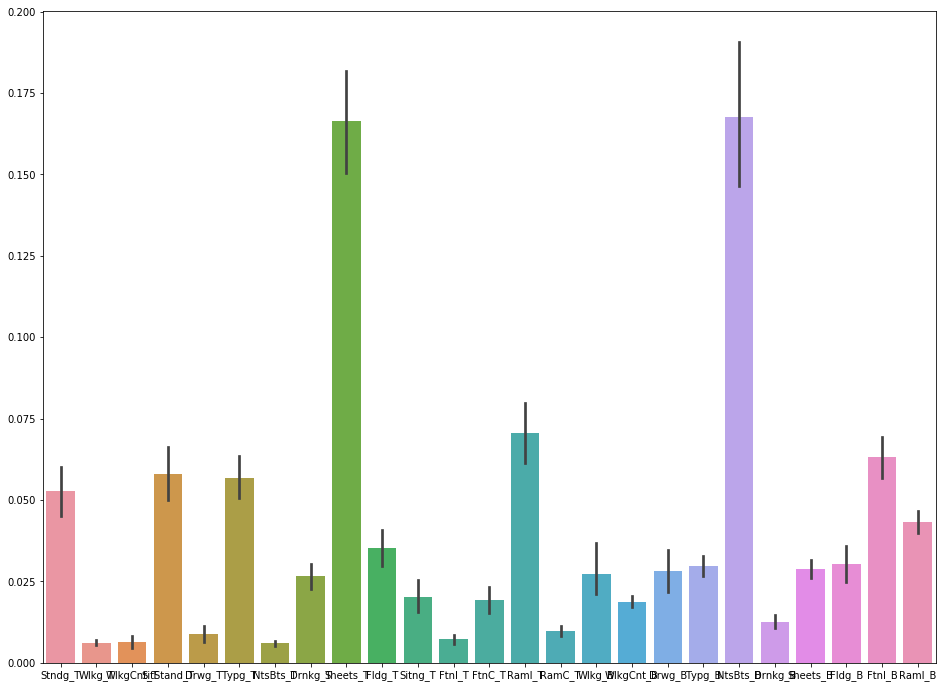

In [34]:
plt.figure(figsize=(16,12))
sns.barplot(data = pd.DataFrame(FeatImp,columns = AllScores.columns))

In [35]:
FeatImp

array([[0.06084491, 0.00835171, 0.01973944, 0.01774684, 0.01133143,
        0.09398356, 0.00252588, 0.01899268, 0.11290043, 0.04538792,
        0.02712794, 0.01525763, 0.02023727, 0.02840566, 0.01457523,
        0.02741481, 0.0194706 , 0.07519982, 0.04865429, 0.0770181 ,
        0.0146885 , 0.04851102, 0.06589986, 0.09844164, 0.02729282],
       [0.05508394, 0.00903922, 0.00872504, 0.06248972, 0.00309344,
        0.02302393, 0.00765907, 0.04135505, 0.19402836, 0.02337648,
        0.01590442, 0.0056946 , 0.01608614, 0.08216217, 0.01481063,
        0.01295361, 0.01150014, 0.01600839, 0.02775065, 0.18595208,
        0.0233078 , 0.03176006, 0.03078226, 0.06891124, 0.02854157],
       [0.05013588, 0.00478226, 0.00617131, 0.04797893, 0.00387708,
        0.05766155, 0.00543282, 0.00704556, 0.17258134, 0.04016699,
        0.00548164, 0.00710861, 0.00984987, 0.09494003, 0.01559835,
        0.02818189, 0.01461169, 0.05067352, 0.03049569, 0.1860557 ,
        0.01130077, 0.02440422, 0.02265046, 0.

In [36]:
Outcomes

UPDRS Part III  \
1003.0 2 Weeks: Time 0                (28.88, 59.0)   
       2 Weeks: Time 60              (18.315, 40.0)   
1004.0 2 Weeks: Time 0                 (25.0, 31.0)   
1005.0 2 Weeks: Time 0                (33.06, 33.0)   
       2 Weeks: Time 60               (31.66, 32.0)   
1007.0 2 Weeks: Time 0                (20.16, 33.0)   
       2 Weeks: Time 60              (10.776, 16.0)   
1009.0 2 Weeks: Time 0                (31.34, 55.0)   
       2 Weeks: Time 60               (20.36, 26.0)   
1016.0 2 Weeks: Time 0                (26.56, 19.0)   
       2 Weeks: Time 60               (26.16, 21.0)   
1018.0 2 Weeks: Time 0                (27.74, 18.0)   
       2 Weeks: Time 60                (26.4, 13.0)   
1019.0 2 Weeks: Time 0                (18.46, 36.0)   
       2 Weeks: Time 60               (18.58, 14.0)   
1023.0 2 Weeks: Time 0                 (34.4, 36.0)   
       2 Weeks: Time 60               (17.81, 21.0)   
1024.0 2 Weeks: Time 60               (23.18, 18.0)   
1029.0 2 Weeks: Time 0                (28.46, 42.0)   
       2 Weeks: Time 60               (22.22, 32.0)   
1030.0 2 Weeks: Time 0                 (16.9, 18.0)   
1032.0 2 Weeks: Time 0                (29.18, 28.0)   
       2 Weeks: Time 60               (25.04, 12.0)   
1038.0 2 Weeks: Time 0                (35.52, 30.0)   
       2 Weeks: Time 60               (36.14, 25.0)   
1039.0 2 Weeks: Time 0                (26.06, 29.0)   
       2 Weeks: Time 60               (19.54, 12.0)   
1043.0 2 Weeks: Time 0                (41.62, 40.0)   
       2 Weeks: Time 60  (19.035999999999998, 16.0)   
1044.0 2 Weeks: Time 0                (18.28, 29.0)   
       2 Weeks: Time 60  (11.721428571428572, 24.0)   
1046.0 2 Weeks: Time 0                (21.88, 21.0)   
       2 Weeks: Time 60               (24.96, 18.0)   
1047.0 2 Weeks: Time 0               (20.553, 18.0)   
       2 Weeks: Time 60               (18.838, 9.0)   
1048.0 2 Weeks: Time 0                (32.36, 16.0)   
1049.0 2 Weeks: Time 60               (30.98, 24.0)   
1050.0 2 Weeks: Time 0                (37.84, 40.0)   
       2 Weeks: Time 60               (23.32, 24.0)   
1051.0 2 Weeks: Time 0                (16.98, 14.0)   
       2 Weeks: Time 60   (17.379000000000005, 6.0)   
1052.0 2 Weeks: Time 0                (26.68, 31.0)   
       2 Weeks: Time 60               (16.72, 15.0)   
1053.0 2 Weeks: Time 0                (16.64, 25.0)   
       2 Weeks: Time 60               (16.74, 15.0)   
1054.0 2 Weeks: Time 0                (33.02, 44.0)   
       2 Weeks: Time 60               (19.96, 15.0)   
1055.0 2 Weeks: Time 0                (42.24, 36.0)   
       2 Weeks: Time 60               (34.28, 26.0)   
1056.0 2 Weeks: Time 0                (39.16, 46.0)   
       2 Weeks: Time 60               (41.76, 61.0)   

                                    UPDRS Rigidity                UPDRS Upper  \
1003.0 2 Weeks: Time 0                 (3.52, 9.0)               (6.72, 13.0)   
       2 Weeks: Time 60   (1.681904761904762, 9.0)  (5.833333333333332, 12.0)   
1004.0 2 Weeks: Time 0                  (1.8, 5.0)                 (6.2, 9.0)   
1005.0 2 Weeks: Time 0                 (7.06, 7.0)                (9.88, 8.0)   
       2 Weeks: Time 60                (6.28, 7.0)                (9.22, 8.0)   
1007.0 2 Weeks: Time 0                 (4.38, 5.0)  (6.986666666666666, 10.0)   
       2 Weeks: Time 60  (2.8470000000000004, 0.0)  (4.0200000000000005, 7.0)   
1009.0 2 Weeks: Time 0                (5.56, 13.0)                (6.7, 12.0)   
       2 Weeks: Time 60                 (3.0, 7.0)                 (4.3, 5.0)   
1016.0 2 Weeks: Time 0                 (4.76, 0.0)                (7.64, 6.0)   
       2 Weeks: Time 60                (4.08, 0.0)                (5.52, 5.0)   
1018.0 2 Weeks: Time 0                 (4.18, 4.0)                (7.26, 5.0)   
       2 Weeks: Time 60                (5.04, 3.0)                (6.96, 3.0)   
1019.0 2 Weeks: Time 0                 (2.

UPDRS Part III 72.45335746069006 2.7130111824487466 -1.1990504201680665 10.174640229424492 (0.5899803721174451, 5.210259008442167e-06)
UPDRS Rigidity 24.604998416799443 5.729931138158775 0.10231092436974785 3.4781377295995273 (0.1473182785837674, 0.30224871181394375)
UPDRS Upper 21.609111233967848 3.231861210945338 -0.13819981325863678 3.0528007786764424 (0.4333471335898894, 0.0014906441438526958)
UPDRS Lower 17.612341226381282 3.9223991377530365 -0.08003221288515414 2.4894493389680608 (0.2058160014786943, 0.1473527384018977)
UPDRS Posture/Gait 14.233736420951942 5.1121166018911905 -0.14481512605042016 2.0076339808030292 (0.46130225629310695, 0.000656785158176268)
UPDRS Bradykinesia 4.96588095004072 3.0149991482390086 0.017228758169934636 0.7020660264457375 (0.050955079226090924, 0.7225135082449639)
UPDRS Tremor 22.530106793460092 5.222888393029385 -0.30420074696545285 3.1713917112445924 (0.7855709668823624, 8.695417478285949e-12)


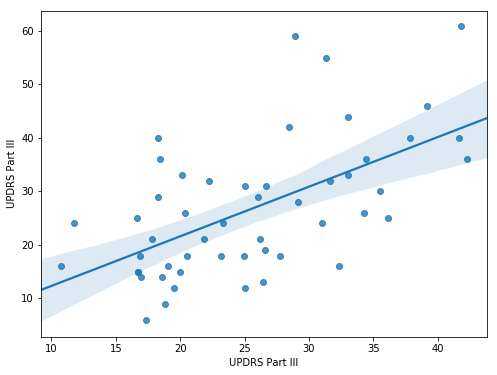

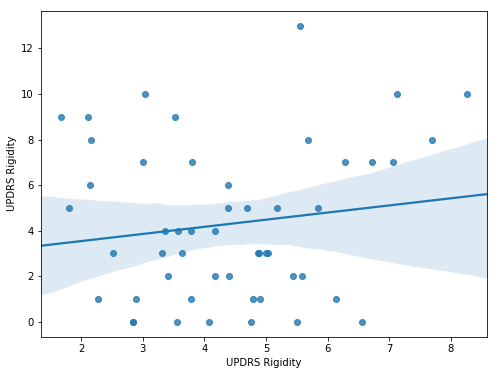

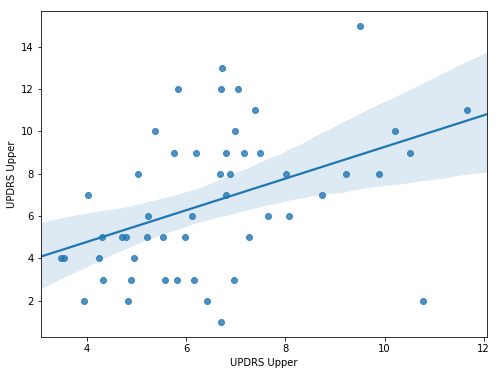

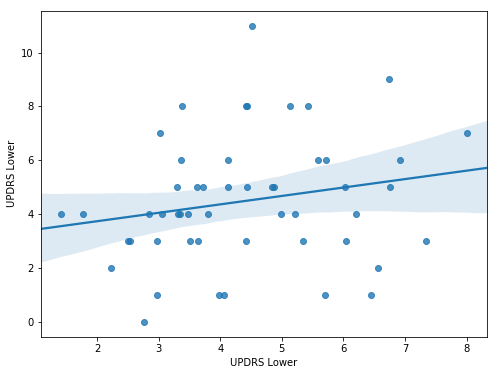

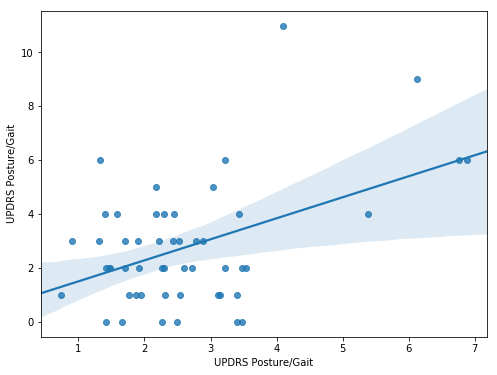

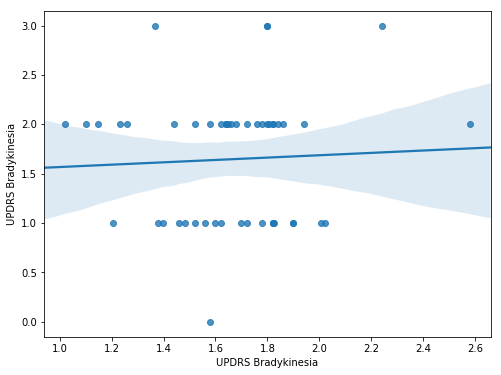

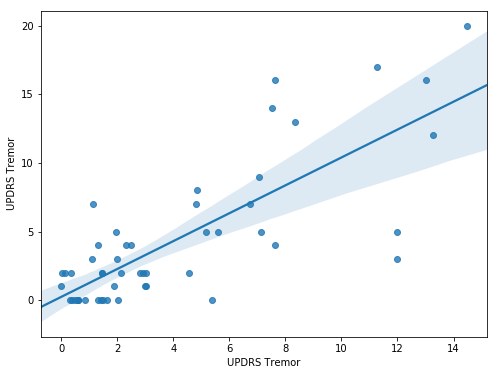

In [39]:
for column in Outcomes.columns:
    S = Outcomes[column].apply(lambda x: (x[0]-x[1])**2).sum()
    M = Outcomes[column].apply(lambda x: x[1]).mean()
    MD = Outcomes[column].apply(lambda x: (x[0]-x[1])).mean()
    SD = Outcomes[column].apply(lambda x: (x[0]-x[1])).std()
    print(column, np.sqrt(S), np.sqrt(S)/M, MD, SD, 
          pearsonr(Outcomes[column].apply(lambda x: x[0]),Outcomes[column].apply(lambda x: x[1])))
    plt.figure(figsize=(8,6))
    sns.regplot(Outcomes[column].apply(lambda x: x[0]),Outcomes[column].apply(lambda x: x[1]))

In [ ]:

sns.regplot(Outcomes[column].apply(lambda x: x[0]),Outcomes[column].apply(lambda x: x[1]))

## Ipsilateral vs. Contralateral Scores

In [7]:
BilatScores = pd.DataFrame()

In [21]:
BilatScores = pd.DataFrame()
for ind in D.index:
    row = D.loc[ind,:]
    side = row.Q03
    try:
        side = side.lower()
        otherside = (set(['left','right'])-set([side]))
        otherside = [x for x in otherside][0]
    except(AttributeError):
        print(row.SubjectCode, row.VisitNm, row.Q03)
        continue
    for task, task_abr in zip(taskList,taskList_Abb):
        newind = len(BilatScores.index)
        RowScores = pd.DataFrame(columns=['ipsi', 'contra'], index=[ind])
        QInd = Questions.zFieldNm==task+' tremor '+side+' upper limb rating'
        QNum = Questions[QInd].zFieldNb
        RowScores['ipsi'] = row[QNum].values[0]
        QInd = Questions.zFieldNm==task+' tremor '+otherside+' upper limb rating'
        QNum = Questions[QInd].zFieldNb
        RowScores['contra'] = row[QNum].values[0]
        
        BilatScores = pd.concat((BilatScores,RowScores))

1005.0 2 Weeks: Time 120 nan
1005.0 1 Month nan
1020.0 2 Weeks: Time 0 nan
1020.0 2 Weeks: Time 30 nan
1020.0 2 Weeks: Time 60 nan
1020.0 2 Weeks: Time 90 nan
1020.0 2 Weeks: Time 120 nan
1020.0 2 Weeks: Time 150 nan
1047.0 1 Month nan
1048.0 2 Weeks: Time 150 nan


In [10]:
BilatScores.corr()

,left,right
left,1.000000,0.342239
right,0.342239,1.000000


In [22]:
BilatScores.corr()

,ipsi,contra
ipsi,1.000000,0.407596
contra,0.407596,1.000000


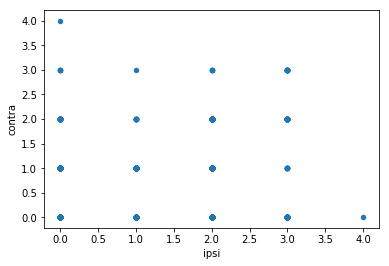

In [25]:
BilatScores.plot(x='ipsi',y='contra',kind = 'scatter')

In [53]:
BilatScoreCounts = pd.DataFrame(columns=[0, 1, 2, 3, 4], index = [0, 1, 2, 3, 4])
for x,y in itertools.product([0,1,2,3,4],[0,1,2,3,4]):
    BilatScoreCounts.loc[x,y] = sum((BilatScores.ipsi==x)&(BilatScores.contra==y))/sum(BilatScores.ipsi==x)

In [54]:
BilatScoreCounts = BilatScoreCounts[BilatScoreCounts.columns].astype(float)

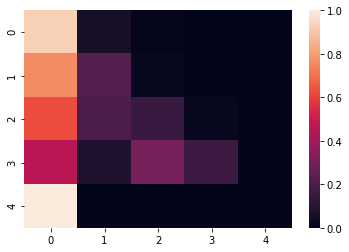

In [55]:
sns.heatmap(BilatScoreCounts)